In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns

#Baseline heterogeneity was quantified using coefficients of variation for multiple base saturation, pH, and Mg. Sampling density per plot was determined using the maximum observed coefficient across indicators to ensure robustness under worst-case heterogeneity. Plots exhibiting high baseline variability (anything above .4) would need more sampling density than more homogeneous plots, but results give a minimum number of paired sampling locations to ensure compliance


In [2]:
GCP1_pre_and_post = pd.read_csv("GCP1_pre_and_post.csv")

In [3]:
GCP1_ALS_midterm = pd.read_csv("GCP1_ALS_midterm.csv",skiprows=8, header=None)

In [4]:
MWLpre_pH = GCP1_pre_and_post.loc[
    (GCP1_pre_and_post["Report Date"] == "2024-09-06") &
    (~GCP1_pre_and_post["Info3"].str.contains("control", case=False, na=False)),
    "PH"
]
#MWLpre_pH.head(10)

In [5]:
MWLpost_pH = GCP1_pre_and_post.loc[
    (GCP1_pre_and_post["Report Date"] == "2024-10-02") &
    (~GCP1_pre_and_post["Info3"].str.contains("control", case=False, na=False)),
    "PH"]

#MWLpost_pH.head(10)

#Across 36 paired soil samples, mean pH increased by 0.19 ± 0.44 units following application, and the increase was statistically significant (paired t-test, t(35)=2.60, p=0.014). This indicates a consistent alkalinity response attributable to treatment rather than random variability.

In [6]:
delta = MWLpost_pH.values - MWLpre_pH.values
delta.mean(), delta.std(ddof=1)

(0.18888888888888883, 0.43672664073784034)

In [7]:
#filter
df = GCP1_pre_and_post[
    (~GCP1_pre_and_post["Info3"].str.contains("control", case=False, na=False)) &
    (GCP1_pre_and_post["Report Date"].isin(["2024-09-06", "2024-10-02"]))
]


In [8]:
#average within plot
df_mean = (
    df.groupby(["Info3", "Report Date"])["PH"]
      .mean()
      .reset_index()
)


In [9]:
#pivot
wide = df_mean.pivot(index="Info3", columns="Report Date", values="PH")
wide = wide.dropna()   # only plots with both dates

In [10]:
#paired delta and t test
pre  = wide["2024-09-06"]
post = wide["2024-10-02"]

delta = post - pre

delta.mean(), delta.std(ddof=1)
stats.ttest_rel(pre, post)


TtestResult(statistic=-3.410246130711429, pvalue=0.019038270891454056, df=5)

In [11]:
import scipy.stats as stats

stats.ttest_rel(
    MWLpre_pH.sort_index(),
    MWLpost_pH.sort_index()
)

TtestResult(statistic=-2.595063427819724, pvalue=0.0137254452910393, df=35)

In [12]:
print(np.var(MWLpre_pH),np.var(MWLpost_pH))

0.07654320987654321 0.09450617283950621


In [13]:
Mg_pre = GCP1_pre_and_post.loc[
    (GCP1_pre_and_post["Report Date"] == "2024-09-06") &
    (~GCP1_pre_and_post["Info3"].str.contains("control", case=False, na=False)),
    "Mg ppm"
]
Mg_pre.head(10)

0    3374
1    2714
2    2170
3    2496
4    2421
5    2887
6    5106
7    5364
8    5687
9    5235
Name: Mg ppm, dtype: int64

In [14]:
Mg_post = GCP1_pre_and_post.loc[
    (GCP1_pre_and_post["Report Date"] == "2024-10-02") &
    (~GCP1_pre_and_post["Info3"].str.contains("control", case=False, na=False)),
    "Mg ppm"
]
Mg_post.head(10)

42    7317
43    4955
44    4736
45    5083
46    5507
47    5218
48    5529
49    6147
50    5712
51    6257
Name: Mg ppm, dtype: int64

In [15]:
print(np.var(Mg_pre),np.var(Mg_post))

1108308.4691358025 1804207.193672839


In [16]:
#the ratio indicates that pre and post DO NOT have equal variance

In [17]:
import scipy.stats as stats

stats.ttest_rel(
    Mg_pre.sort_index(),
    Mg_post.sort_index()
)

TtestResult(statistic=-2.4483741663551677, pvalue=0.01950410621435506, df=35)

In [18]:
#Magnesium concentrations increased significantly from baseline to post-application (paired t-test, t(35) = 2.45, p = 0.019).

In [19]:
#Magnitude of change
delta = Mg_post.values - Mg_pre.values
delta.mean(), delta.std(ddof=1)

(539.4166666666666, 1321.8976267904734)

In [20]:
#Report effect size (Cohen’s dz)
dz = delta.mean() / delta.std(ddof=1)
dz

0.4080623610591946

In [21]:
#good results so far
stats.wilcoxon(Mg_pre, Mg_post)

WilcoxonResult(statistic=188.0, pvalue=0.02272249623325208)

In [22]:
baseline = GCP1_pre_and_post.loc[
    GCP1_pre_and_post["Report Date"] == "2024-09-06"
].copy()

# strip whitespace from grouping columns (important)
baseline["Info2"] = baseline["Info2"].astype(str).str.strip()
baseline["Info3"] = baseline["Info3"].astype(str).str.strip()

In [23]:
#distinguish the control portion from the rest of baseline samples
baseline["is_control"] = baseline["Info3"].str.contains(
    "control", case=False, na=False
)
baseline["is_control"].value_counts()

is_control
False    36
True      6
Name: count, dtype: int64

In [24]:
control = baseline.loc[baseline["is_control"], "CEC"]
treat   = baseline.loc[~baseline["is_control"], "CEC"]

stats.ttest_ind(control, treat, equal_var=False)


TtestResult(statistic=-3.770896604949649, pvalue=0.0005266686904284367, df=39.98878728654767)

In [25]:
control = baseline.loc[baseline["is_control"], "PH"]
treat   = baseline.loc[~baseline["is_control"], "PH"]

stats.ttest_ind(control, treat, equal_var=False)


TtestResult(statistic=1.9920123932013825, pvalue=0.07648443020406016, df=9.310886923665954)

In [26]:
baseline["BaseSaturation_pct"] = (
    baseline["PERCENTCA"] +
    baseline["PERCENTMG"] +
    baseline["PERCENTK"] +
    baseline["PERCENTNA"]
)
#baseline["BaseSaturation_pct"].head(10)
baseline["BaseSaturation_pct"].describe()

count    42.000000
mean     65.554762
std       8.271615
min      46.100000
25%      59.000000
50%      65.650000
75%      71.775000
max      79.400000
Name: BaseSaturation_pct, dtype: float64

In [27]:
baseline["is_control"] = baseline["Info3"].str.contains(
    "control", case=False, na=False
)


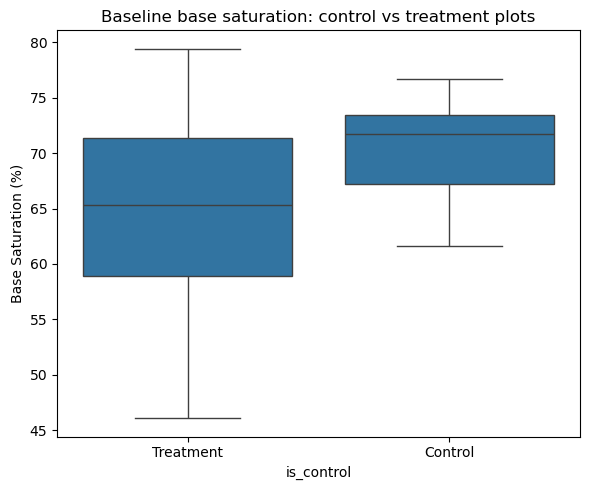

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.boxplot(
    data=baseline,
    x="is_control",
    y="BaseSaturation_pct"
)
plt.xticks([0, 1], ["Treatment", "Control"])
plt.ylabel("Base Saturation (%)")
plt.title("Baseline base saturation: control vs treatment plots")
plt.tight_layout()
plt.show()


In [29]:
#Baseline base saturation varied across the site, with control plots exhibiting slightly higher median values than treatment plots but substantial overlap between distributions, consistent with expected spatial heterogeneity in non-contiguous agricultural soils.

In [30]:
baseline["is_control"] = baseline["Info3"].str.contains(
    "control", case=False, na=False
)

baseline["Group"] = baseline["is_control"].map({
    False: "Treatment",
    True: "Control"
})


<Axes: xlabel='Group', ylabel='BaseSaturation_pct'>

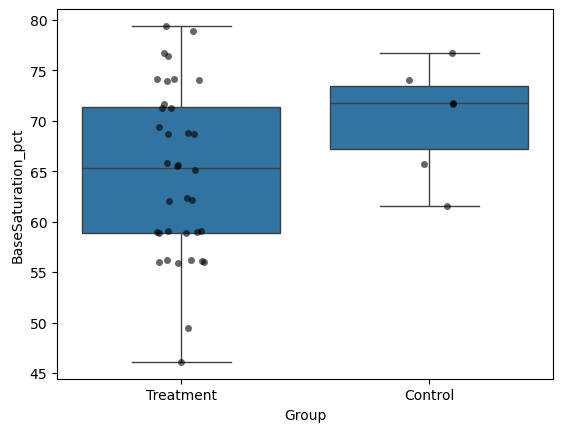

In [31]:
sns.boxplot(
    data=baseline,
    x="Group",
    y="BaseSaturation_pct"
)

sns.stripplot(
    data=baseline,
    x="Group",
    y="BaseSaturation_pct",
    color="black",
    alpha=0.6,
    jitter=True
)


In [32]:
baseline["BaseSaturation_pct"] = (
    baseline["PERCENTCA"] +
    baseline["PERCENTMG"] +
    baseline["PERCENTK"] +
    baseline["PERCENTNA"]
)
baseline["BaseSaturation_pct"].head(10)

0    62.3
1    56.2
2    58.9
3    68.7
4    76.4
5    58.9
6    49.5
7    56.1
8    56.0
9    59.0
Name: BaseSaturation_pct, dtype: float64

In [33]:
# 1) Define baseline
baseline = GCP1_pre_and_post.loc[
    GCP1_pre_and_post["Report Date"] == "2024-09-06"
].copy()

# 2) Identify controls
baseline["is_control"] = baseline["Info3"].astype(str).str.contains(
    "control", case=False, na=False
)

# 3) Compute base saturation (must exist before grouping)
baseline["BaseSaturation_pct"] = (
    baseline["PERCENTCA"] +
    baseline["PERCENTMG"] +
    baseline["PERCENTK"] +
    baseline["PERCENTNA"]
)


In [34]:
# focus on treatment plots only
baseline_t = baseline.loc[~baseline["is_control"]].copy()

within_plot = (
    baseline_t
    .groupby("Info3")["BaseSaturation_pct"]
    .agg(["count", "mean", "std"])
)

within_plot["cv"] = within_plot["std"] / within_plot["mean"]
within_plot.sort_values("cv", ascending=False)


,count,mean,std,cv
Info3,,,,
ROBERTS,6,63.566667,7.621986,0.119905
BOYER E,6,56.983333,6.372258,0.111827
CARL DERRICK E,6,69.350000,5.928491,0.085487
CALEB PAYNE,6,67.933333,4.382997,0.064519
BOYER W,6,55.950000,3.488696,0.062354
CARL DERRICK M TREATMENT,6,74.850000,2.618205,0.034979


In [35]:
baseline = GCP1_pre_and_post.loc[
    GCP1_pre_and_post["Report Date"] == "2024-09-06"
].copy()

baseline["is_control"] = baseline["Info2"].astype(str).str.contains(
    "control", case=False, na=False
)

baseline["BaseSaturation_pct"] = (
    baseline["PERCENTCA"] +
    baseline["PERCENTMG"] +
    baseline["PERCENTK"] +
    baseline["PERCENTNA"]
)

In [36]:
def within_plot_cv(df, value_col, plot_col="Info3", exclude_controls=True):
    d = df.copy()
    if exclude_controls and "is_control" in d.columns:
        d = d.loc[~d["is_control"]]
    out = (
        d.groupby(plot_col)[value_col]
        .agg(["count", "mean", "std"])
    )
    out["cv"] = out["std"] / out["mean"]
    return out.sort_values("cv", ascending=False)


In [37]:
cv_pH = within_plot_cv(baseline, "PH")
cv_pH

,count,mean,std,cv
Info3,,,,
ROBERTS,6,5.150000,0.258844,0.050261
BOYER E,6,4.933333,0.196638,0.039859
CARL DERRICK E,6,5.333333,0.206559,0.038730
CARL DERRICK W CONTROL,6,5.366667,0.186190,0.034694
CALEB PAYNE,6,5.283333,0.147196,0.027860
BOYER W,6,4.900000,0.109545,0.022356
CARL DERRICK M TREATMENT,6,5.533333,0.103280,0.018665


In [38]:
cv_Mg = within_plot_cv(baseline, "MG ppm")
cv_Mg

,count,mean,std,cv
Info3,,,,
CALEB PAYNE,6,207.166667,177.670951,0.857623
BOYER E,6,193.166667,137.426950,0.711442
ROBERTS,6,256.500000,172.670495,0.673179
BOYER W,6,293.833333,56.346843,0.191765
CARL DERRICK W CONTROL,6,91.833333,14.905256,0.162308
CARL DERRICK M TREATMENT,6,104.500000,15.201974,0.145473
CARL DERRICK E,6,105.833333,11.513760,0.108791


In [39]:
cv_bs  = within_plot_cv(baseline, "BaseSaturation_pct")
cv_pH  = within_plot_cv(baseline, "PH")        
cv_Mg  = within_plot_cv(baseline, "MG ppm")

cv_compare = (
    cv_bs[["cv"]].rename(columns={"cv": "cv_bs"})
    .join(cv_pH[["cv"]].rename(columns={"cv": "cv_pH"}))
    .join(cv_Mg[["cv"]].rename(columns={"cv": "cv_Mg"}))
)

cv_compare["cv_max"] = cv_compare.max(axis=1)
cv_compare.sort_values("cv_max", ascending=False)

,cv_bs,cv_pH,cv_Mg,cv_max
Info3,,,,
CALEB PAYNE,0.064519,0.027860,0.857623,0.857623
BOYER E,0.111827,0.039859,0.711442,0.711442
ROBERTS,0.119905,0.050261,0.673179,0.673179
BOYER W,0.062354,0.022356,0.191765,0.191765
CARL DERRICK W CONTROL,0.079434,0.034694,0.162308,0.162308
CARL DERRICK M TREATMENT,0.034979,0.018665,0.145473,0.145473
CARL DERRICK E,0.085487,0.038730,0.108791,0.108791


In [40]:
cv_compare["cv_max"] = cv_compare.max(axis=1)
cv_compare.sort_values("cv_max", ascending=False)
#values above .4 are high for soil co-variance (see isometric) and this shows high variability affecting the sampling plan given the fact that there is very low homogeneity. 
#This means that we need to stratify by plot
#allocate many more samples to the high covariance plots I have here
#avoid one-size-fits-all sampling density

,cv_bs,cv_pH,cv_Mg,cv_max
Info3,,,,
CALEB PAYNE,0.064519,0.027860,0.857623,0.857623
BOYER E,0.111827,0.039859,0.711442,0.711442
ROBERTS,0.119905,0.050261,0.673179,0.673179
BOYER W,0.062354,0.022356,0.191765,0.191765
CARL DERRICK W CONTROL,0.079434,0.034694,0.162308,0.162308
CARL DERRICK M TREATMENT,0.034979,0.018665,0.145473,0.145473
CARL DERRICK E,0.085487,0.038730,0.108791,0.108791


In [48]:
plot_col = "Info3"
pair_col = "Sample ID"
mg_col   = "MG ppm"
ph_col   = "PH"  

#df_nc = df.loc[~df["is_control"]]

pre = df_nc.loc[df_nc["Report Date"] == date_pre,
                [plot_col, pair_col, mg_col, ph_col]].set_index([plot_col, pair_col])

post = df_nc.loc[df_nc["Report Date"] == date_post,
                 [plot_col, pair_col, mg_col, ph_col]].set_index([plot_col, pair_col])

pairs = pre.join(post, lsuffix="_pre", rsuffix="_post", how="inner")

pairs["d_MG"] = pairs[f"{mg_col}_post"] - pairs[f"{mg_col}_pre"]
pairs["d_PH"] = pairs[f"{ph_col}_post"] - pairs[f"{ph_col}_pre"]

pairs.head(), pairs.shape


NameError: name 'df_nc' is not defined

In [49]:
date_pre  = "2024-09-06"
date_post = "2024-10-02"

df = GCP1_pre_and_post.copy()

# control samples
df["is_control"] = df["Info3"].astype(str).str.contains("control", case=False, na=False)

# Keep only non-control samples
df = df.loc[~df["is_control"]].copy()

pre = df.loc[df["Report Date"] == date_pre,  [plot_col, pair_col, mg_col, ph_col]].copy()
post= df.loc[df["Report Date"] == date_post, [plot_col, pair_col, mg_col, ph_col]].copy()

# index the pairs
pre  = pre.set_index([plot_col, pair_col]).sort_index()
post = post.set_index([plot_col, pair_col]).sort_index()

# Keep only pairs that exist in both
pairs = pre.join(post, lsuffix="_pre", rsuffix="_post", how="inner")

pairs["d_MG"] = pairs[f"{mg_col}_post"] - pairs[f"{mg_col}_pre"]
pairs["d_PH"] = pairs[f"{ph_col}_post"] - pairs[f"{ph_col}_pre"]

pairs.head()


MG ppm_pre  PH_pre  MG ppm_post  PH_post  d_MG  d_PH
Info3   Sample ID                                                      
BOYER E Composite         191     5.0          247      5.1    56   0.1
        Z1                100     4.9          122      5.2    22   0.3
        Z2                 53     4.9           68      5.1    15   0.2
        Z3                372     5.2          504      5.3   132   0.1
        Z4                349     5.0          452      5.3   103   0.3

In [43]:
from statsmodels.stats.power import TTestPower

analysis = TTestPower()

sd_d_MG = pairs["d_MG"].std(ddof=1)
sd_d_PH = pairs["d_PH"].std(ddof=1)

# choose detection targets
delta_MG = 50    
delta_PH = 0.15  

dz_MG = delta_MG / sd_d_MG
dz_PH = delta_PH / sd_d_PH

n_MG_80 = analysis.solve_power(
    effect_size=abs(dz_MG),
    power=0.80,
    alpha=0.05,
    alternative="two-sided"
)

n_PH_80 = analysis.solve_power(
    effect_size=abs(dz_PH),
    power=0.80,
    alpha=0.05,
    alternative="two-sided"
)

n_MG_80, n_PH_80


(12.315241277811428, 13.957659150809151)

In [44]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import TTestPower

analysis = TTestPower()

def n_required_from_sd(sd_diff, delta, power=0.80, alpha=0.05):
    dz = delta / sd_diff
    return analysis.solve_power(effect_size=abs(dz), power=power, alpha=alpha, alternative="two-sided")

per_plot = (
    pairs.groupby(level=0)[["d_MG", "d_PH"]]
    .agg(["count", "mean", "std"])
)

# simplify column names
per_plot.columns = ["_".join(c).strip() for c in per_plot.columns.to_flat_index()]
per_plot = per_plot.rename(columns={
    "d_MG_count": "n_pairs_pilot",
    "d_MG_std": "sd_d_MG",
    "d_PH_std": "sd_d_PH",
    "d_MG_mean": "mean_d_MG",
    "d_PH_mean": "mean_d_PH",
})

per_plot


,n_pairs_pilot,mean_d_MG,sd_d_MG,d_PH_count,mean_d_PH,sd_d_PH
Info3,,,,,,
BOYER E,6,57.166667,49.989666,6,0.200000,0.089443
BOYER W,6,-47.166667,89.916443,6,0.400000,0.141421
CALEB PAYNE,6,31.666667,32.690468,6,0.233333,0.150555
CARL DERRICK E,6,10.500000,16.355427,6,0.016667,0.183485
CARL DERRICK M TREATMENT,6,10.500000,8.117881,6,0.216667,0.147196
ROBERTS,6,-2.666667,59.473243,6,0.066667,0.150555


Statistical Power doesn't make sense for this project because our project claims require plot specific detection of treatment-driven change, power calculations were performed independently for each plot using a paired sampling design (matched locations at baseline and post-application). For each plot, the standard deviation of paired differences was estimated from pilot paired observations, and the number of paired monitoring locations was selected to achieve ≥80% power (α = 0.05, two-sided) to detect a mean change of at least .15 for pH and 50ppm for Mg. The final sampling density per plot was set to the maximum required across pH and Mg, ensuring ≥80% power for both endpoints within each plot.

In [45]:
from statsmodels.stats.power import TTestPower
analysis = TTestPower()

n = 13
dz_80 = analysis.solve_power(nobs=n, power=0.80, alpha=0.05, alternative="two-sided")

mde_MG = dz_80 * sd_d_MG
mde_PH = dz_80 * sd_d_PH

mde_MG, mde_PH


(48.39483601926029, 0.1564797787415753)